In [1]:
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
from pylab import rcParams
import matplotlib.font_manager
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as ptick
import os

In [2]:
def standard_benefit_pv(r, q, sigma, S, T, K):
    d_plus = (np.log(S/K) + (r-q + 0.5 * sigma * sigma) * T) / (sigma * np.sqrt(T))
    d_minus = d_plus - sigma * np.sqrt(T)
    return np.exp(- r * T) * K * norm.cdf(- d_minus) - np.exp(- q * T) * S * norm.cdf(- d_plus)

def standard_income_pv(q, S, T):
    return S * (1 - np.exp(- q * T))

def d_1(nu, k, x, T):
    return (-k +x + nu * T) / np.sqrt(T)

def d_3(nu, k, x, T):
    return (-k -x + nu * T) / np.sqrt(T)

def d_5(nu, k, x, t):
    return (-k -x + nu * t) / np.sqrt(t)

def d_7(nu, k, t):
    return (-k + nu * t) / np.sqrt(t)

def C_1(nu, x, T_minus_t):
    return 1 - x * x / (T_minus_t) - nu * x;

def C_2(nu, k, x, t, T_minus_t):
    return C_1(nu, x, T_minus_t) / np.sqrt(t) - x * k / (t * np.sqrt(t))

def psi_1_integrand(rho, nu, k, x, T, s): 
    t = 0.5 * T * ( np.exp(0.5 * math.pi * np.sinh(s)) / np.cosh(0.5 * math.pi * np.sinh(s)))
    T_minus_t =  0.5 * T * (np.exp( - 0.5 * math.pi * np.sinh(s)) / np.cosh(0.5 * math.pi * np.sinh(s)))

    d_5_ = d_5(nu, k, x, t)
    jacobian = 0.25 * math.pi * T * np.cosh(s)/ pow(np.cosh(0.5 * math.pi * np.sinh(s)) , 2)
    integrand = (1 - np.exp(-rho * (T_minus_t))) * np.exp(0.5 * nu * nu * t) \
                / ( math.sqrt(2 * math.pi) * rho * pow(T_minus_t, 1.5) ) \
                * (nu * norm.cdf(d_5_) + norm.pdf(d_5_) / np.sqrt(t) )
    return integrand * jacobian

def psi_2_integrand(rho, nu, k, x, T, s):
    t = 0.5 * T * ( np.exp(0.5 * math.pi * np.sinh(s)) / np.cosh(0.5 * math.pi * np.sinh(s)))
    T_minus_t =  0.5 * T * (np.exp( - 0.5 * math.pi * np.sinh(s)) / np.cosh(0.5 * math.pi * np.sinh(s)))

    d_7_ = d_7(nu, k, t)
    jacobian = 0.25 * math.pi * T * np.cosh(s) / pow(np.cosh(0.5 * math.pi * np.sinh(s)) , 2)
    integrand = (1 - np.exp(-rho * (T_minus_t))) \
                * np.exp(0.5 * nu * nu * t) \
                / ( math.sqrt(2 * math.pi) * rho * pow(T_minus_t, 1.5) ) \
                * (nu * C_1(nu, x, T_minus_t) * norm.cdf(d_7_) + C_2(nu, k, x, t, T_minus_t) * norm.pdf(d_7_) ) \
                * np.exp(- 0.5 * x * x / (T_minus_t) ) 
    return integrand * jacobian

def psi_1(rho, nu, k, x, T, 
          upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    s = np.linspace(lower_trunc_DE, upper_trunc_DE, grid_num_DE + 1)
    integrand = psi_1_integrand(rho, nu, k, x, T, s)
    ds = (upper_trunc_DE - lower_trunc_DE) / grid_num_DE
    integral = np.sum(integrand) * ds
    return np.exp(nu * x + 0.5 * nu * nu * T) * norm.cdf(d_1(nu, k, x, T)) \
            - np.exp(- nu * x + 0.5 * nu * nu * T) * norm.cdf(d_3(nu, k, x, T)) \
            + np.exp(- nu * x) * integral

def psi_2(rho, nu, k, x, T, 
          upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    s = np.linspace(lower_trunc_DE, upper_trunc_DE, grid_num_DE + 1)
    integrand = psi_2_integrand(rho, nu, k, x, T, s)
    ds = (upper_trunc_DE - lower_trunc_DE) / grid_num_DE
    integral = np.sum(integrand) * ds
    return integral

def psi_3(rho, nu, k, x, T,
          epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    psi_1_val   = psi_1( rho,  nu,       0.0,  x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_2_val_1 = psi_2(-rho, -nu, epsilon_k, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_2_val_2 = psi_2(-rho, -nu,        -k, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return psi_1_val + np.exp(-rho * T) * (psi_2_val_1 - psi_2_val_2)

def psi_4(rho, nu, k, x, T, 
          epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    psi_2_val   = psi_2( rho,  nu, epsilon_k,  x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_1_val_1 = psi_1(-rho, -nu,       0.0, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_1_val_2 = psi_1(-rho, -nu,        -k, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return psi_2_val + np.exp(-rho * T) * (psi_1_val_1 - psi_1_val_2)

def psi(rho, nu, k, x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE): 
    if k >= 0 and x >= 0:
        return psi_1(rho, nu, k, x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    elif k >= 0 and x < 0:
        return psi_2(rho, nu, k, x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    elif k < 0 and x >= 0:
        return psi_3(rho, nu, k, x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    else:
        return psi_4(rho, nu, k, x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)

def benefit_pv(r, q, sigma, rho, S, T, K, B, 
               epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    nu = (r - q - 0.5 * sigma**2) / sigma
    gamma = r + 0.5 * nu * nu
    x = np.log(S/B) / sigma
    k = np.log(K/B) / sigma
    psi_val_1 = psi(rho,         -nu, -k, -x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_val_2 = psi(rho, -(nu+sigma), -k, -x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return np.exp(- gamma * T - nu * x) * (K *  psi_val_1 - B * psi_val_2)

def psi_3_k_neginf(rho, nu, x, T, 
                   epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    psi_1_val = psi_1( rho,  nu,       0.0,  x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_2_val = psi_2(-rho, -nu, epsilon_k, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return psi_1_val + np.exp(-rho * T) * psi_2_val

def psi_4_k_neginf(rho, nu, x, T, 
                   epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    psi_2_val = psi_2( rho,  nu, epsilon_k,  x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    psi_1_val = psi_1(-rho, -nu,       0.0, -x, T, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return psi_2_val + np.exp(-rho * T) * psi_1_val

def psi_k_neginf(rho, nu, x, T, 
                 epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE): 
    if x >= 0:
        return psi_3_k_neginf(rho, nu, x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    else:
        return psi_4_k_neginf(rho, nu, x, T, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)

def income_pv_integrand(r, q, sigma, rho, S, t, B, 
                        epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    if t == 0:
        return S / B
    else:
        nu = (r - q - 0.5 * sigma**2) / sigma
        gamma = r + 0.5 * nu * nu
        x = np.log(S/B) / sigma
        psi_val = psi_k_neginf(rho, -(nu+sigma), -x, t, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
        return np.exp(- gamma * t - nu * x) * psi_val

def income_pv(r, q, sigma, rho, S, T, B, 
              epsilon_k, grid_num_income,
              upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    t_array = np.linspace(0, T, grid_num_income + 1)
    income_pv_integrand_vec = np.vectorize(income_pv_integrand)
    integrand = income_pv_integrand_vec(r, q, sigma, rho, S, t_array, B, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    return q * B * np.trapz(integrand, dx = T / grid_num_income)

In [3]:
r = 0.01
sigma = 0.05
S = 100
T = 10
K = 100

q_no_lapse = optimize.newton(lambda x: standard_benefit_pv(r, x, sigma, S, T, K) - standard_income_pv(x, S, T), x0 = 0.0)

print("解約を考慮しないときの最低保証費用率: ", q_no_lapse)
benefit_pv_no_lapse = standard_benefit_pv(r, q_no_lapse, sigma, S, T, K)
print("解約を考慮しないときの給付現価: ", benefit_pv_no_lapse)
income_pv_no_lapse = standard_income_pv(q_no_lapse, S, T)
print("解約を考慮しないときの収入現価: ", income_pv_no_lapse)

解約を考慮しないときの最低保証費用率:  0.0033575087673688667
解約を考慮しないときの給付現価:  3.3017699946074437
解約を考慮しないときの収入現価:  3.3017699946074286


### 図7: 計算前提

In [4]:
r = 0.01
q = q_no_lapse
sigma = 0.05
rho = - np.log(0.90)
S = 100
T = 10
K = 100
B = 100

epsilon_k = 0.0001
grid_num_income = 20
upper_trunc_DE = 4.0
lower_trunc_DE = -4.0
grid_num_DE = 200

nu = (r - q - 0.5 * sigma**2) / sigma
x = np.log(S/B) / sigma
k = np.log(K/B) / sigma

### 図7

rho  0.10536051565782628 , nu 0.10784982465262266 , S 100 , B 100 , T 10


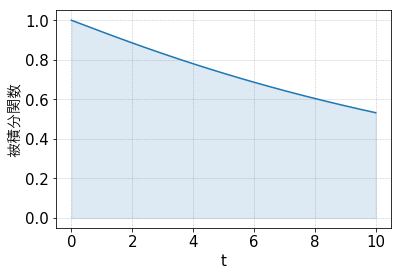

In [5]:
def income_pv_print(r, q, sigma, rho, S, T, B, 
              epsilon_k, grid_num_income,
              upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    t_array = np.linspace(0, T, grid_num_income + 1)
    income_pv_integrand_vec = np.vectorize(income_pv_integrand)
    integrand = income_pv_integrand_vec(r, q, sigma, rho, S, t_array, B, epsilon_k, upper_trunc_DE, lower_trunc_DE, grid_num_DE)
    
    
    print("rho ", rho, ", nu", nu, ", S", S, ", B", B, ", T", T)
    plt.plot(t_array, integrand)
    cmap = plt.get_cmap("tab10") 
    plt.fill_between(t_array, np.zeros(len(t_array)), integrand, facecolor='y', alpha=0.15, color =cmap(0))
    plt.grid(which = "major", axis = "x", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    plt.xlabel("t", fontsize=15)
    fontprop = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/HGRGM.TTC")
    plt.ylabel(u"被積分関数", fontsize=15, fontdict = {"fontproperties": fontprop})
    plt.tick_params(labelsize=15)
    os.makedirs('figure_appendix_F', exist_ok=True)
    plt.savefig('figure_appendix_F/integrand_time.png', bbox_inches="tight")
    
income_pv_print(r, q, sigma, rho, S, T, B, 
                epsilon_k, grid_num_income,
                upper_trunc_DE, lower_trunc_DE, grid_num_DE)

### 図8: 計算前提

In [6]:
r = 0.01
q = q_no_lapse
sigma = 0.05
rho = - np.log(0.90)
S = 100
T = 10
K = 100
B = 100

epsilon_k = 0.0001
grid_num_income = 20
upper_trunc_DE = 4.0
lower_trunc_DE = -4.0
grid_num_DE = 200

nu = (r - q - 0.5 * sigma**2) / sigma
x = np.log(S/B) / sigma
k = np.log(K/B) / sigma

### 図8 (a)

rho  0.10536051565782628 , nu 0.10784982465262266 , k 0.0 , x 0.0 , T 10


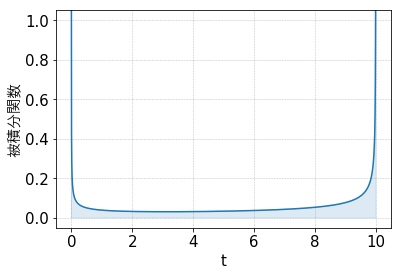

In [7]:
t = np.linspace(0.000001, T - 0.000001, 1000001)
def psi_1_integrand_non_DE_print(rho, nu, k, x, T, t): 
    t = t
    T_minus_t = T - t
    
    d_5_ = d_5(nu, k, x, t)
    integrand = (1 - np.exp(-rho * (T_minus_t))) * np.exp(0.5 * nu * nu * t) \
                / ( math.sqrt(2 * math.pi) * rho * pow(T_minus_t, 1.5) ) \
                * (nu * norm.cdf(d_5_) + norm.pdf(d_5_) / np.sqrt(t) )
    
    print("rho ", rho, ", nu", nu, ", k", k, ", x", x, ", T", T)
    plt.plot(t, integrand)
    plt.ylim([-0.05, 1.05])
    cmap = plt.get_cmap("tab10") 
    plt.fill_between(t, np.zeros(len(t)), integrand, facecolor='y', alpha=0.15, color =cmap(0))
    plt.grid(which = "major", axis = "x", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    plt.xlabel("t", fontsize=15)
    fontprop = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/HGRGM.TTC")
    plt.ylabel(u"被積分関数", fontsize=15, fontdict = {"fontproperties": fontprop})
    plt.tick_params(labelsize=15)
    os.makedirs('figure_appendix_F', exist_ok=True)
    plt.savefig('figure_appendix_F/integrand_1_before.png', bbox_inches="tight")

psi_1_integrand_non_DE_print(rho, nu, k, x, T, t)

### 図8 (b)

rho  0.10536051565782628 , nu 0.10784982465262266 , k 0.0 , x 0.0 , T 10


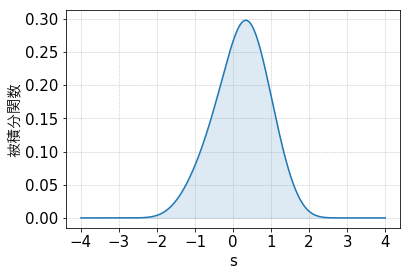

In [8]:
def psi_1_print(rho, nu, k, x, T, 
          upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    s = np.linspace(lower_trunc_DE, upper_trunc_DE, grid_num_DE + 1)
    integrand = psi_1_integrand(rho, nu, k, x, T, s)
    ds = (upper_trunc_DE - lower_trunc_DE) / grid_num_DE
    integral = np.sum(integrand) * ds
    
    print("rho ", rho, ", nu", nu, ", k", k, ", x", x, ", T", T)
    plt.plot(s, integrand)
    cmap = plt.get_cmap("tab10") 
    plt.fill_between(s, np.zeros(len(s)), integrand, facecolor='y', alpha=0.15, color =cmap(0))
    plt.grid(which = "major", axis = "x", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    plt.xticks(np.arange(-4, 4 + 1, 1))
    plt.xlabel("s", fontsize=15)
    fontprop = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/HGRGM.TTC")
    plt.ylabel(u"被積分関数", fontsize=15, fontdict = {"fontproperties": fontprop})
    plt.tick_params(labelsize=15)
    os.makedirs('figure_appendix_F', exist_ok=True) 
    plt.savefig('figure_appendix_F/integrand_1_after.png', bbox_inches="tight")

psi_1_print(rho, nu, k, x, T, 
            upper_trunc_DE, lower_trunc_DE, grid_num_DE=100000)

### 図9: 計算前提

In [9]:
r = 0.01
q = q_no_lapse
sigma = 0.05
rho = - np.log(0.90)
S = 110
T = 10
B = 100

epsilon_k = 0.0001
grid_num_income = 20
upper_trunc_DE = 4.0
lower_trunc_DE = -4.0
grid_num_DE = 200

nu = (r - q - 0.5 * sigma**2) / sigma
x = np.log(S/B) / sigma

### 図9 (a) (b)

rho  0.10536051565782628 , nu -0.15784982465262265 , k 0.0001 , x -1.9062035960864987 , T 10


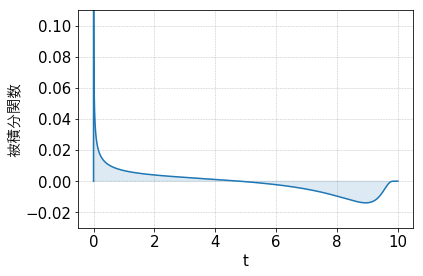

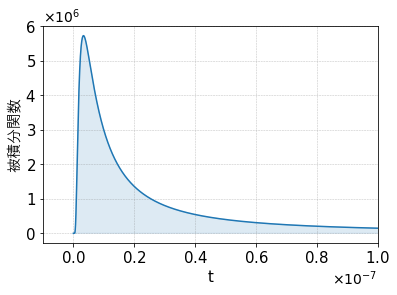

In [10]:
def psi_2_integrand_non_DE_print(rho, nu, k, x, T, t):
    t = t
    T_minus_t = T - t

    d_7_ = d_7(nu, k, t)
    integrand = (1 - np.exp(-rho * (T_minus_t))) \
                * np.exp(0.5 * nu * nu * t) \
                / ( math.sqrt(2 * math.pi) * rho * pow(T_minus_t, 1.5) ) \
                * (nu * C_1(nu, x, T_minus_t) * norm.cdf(d_7_) + C_2(nu, k, x, t, T_minus_t) * norm.pdf(d_7_) ) \
                * np.exp(- 0.5 * x * x / (T_minus_t) ) 

    print("rho ", rho, ", nu", nu, ", k", k, ", x", x, ", T", T)
    plt.plot(t, integrand)
    
    plt.ylim([-0.03, 0.11])
    cmap = plt.get_cmap("tab10") 
    plt.fill_between(t, np.zeros(len(t)), integrand, facecolor='y', alpha=0.15, color =cmap(0))
    plt.grid(which = "major", axis = "x", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    plt.xlabel("t", fontsize=15)
    fontprop = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/HGRGM.TTC")
    plt.ylabel(u"被積分関数", fontsize=15, fontdict = {"fontproperties": fontprop})
    plt.tick_params(labelsize=15)
    os.makedirs('figure_appendix_F', exist_ok=True) 
    plt.savefig('figure_appendix_F/integrand_2_before.png', bbox_inches="tight")
    plt.show()
    
    plt.plot(t, integrand)

    plt.xlim([-0.00000001, 0.0000001])
    cmap = plt.get_cmap("tab10") 
    plt.fill_between(t, np.zeros(len(t)), integrand, facecolor='y', alpha=0.15, color =cmap(0))
    plt.grid(which = "major", axis = "x", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.xaxis.offsetText.set_fontsize(14)
    ax.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
    ax.yaxis.offsetText.set_fontsize(14)
    ax.ticklabel_format(style="sci",  axis="x", scilimits=(0,0))
    ax.ticklabel_format(style="sci",  axis="y", scilimits=(0,0))

    plt.xlabel("t", fontsize=15)
    fontprop = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/HGRGM.TTC")
    plt.ylabel(u"被積分関数", fontsize=15, fontdict = {"fontproperties": fontprop})

    plt.tick_params(labelsize=15)
    plt.savefig('figure_appendix_F/integrand_2_before_zoom.png', bbox_inches="tight")
    
    plt.show()

t = np.hstack((np.linspace(0.00000000001, 0.0000001, 100001), 
               np.linspace(0.0000001, T - 0.00000000001, 100001)))
psi_2_integrand_non_DE_print(rho, -(nu+sigma), epsilon_k, -x, T, t)

### 図9 (c)

rho  0.10536051565782628 , nu -0.15784982465262265 , k 0.0001 , x -1.9062035960864987 , T 10


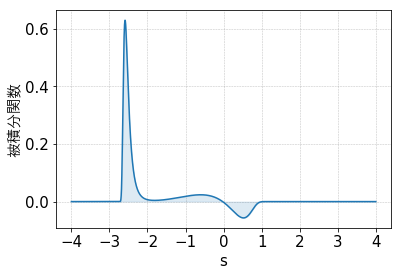

In [11]:
def psi_2_print(rho, nu, k, x, T, 
          upper_trunc_DE, lower_trunc_DE, grid_num_DE):
    s = np.linspace(lower_trunc_DE, upper_trunc_DE, grid_num_DE + 1)
    integrand = psi_2_integrand(rho, nu, k, x, T, s)
    ds = (upper_trunc_DE - lower_trunc_DE) / grid_num_DE
    integral = np.sum(integrand) * ds
    
    print("rho ", rho, ", nu", nu, ", k", k, ", x", x, ", T", T)
    plt.plot(s, integrand)
    cmap = plt.get_cmap("tab10") 
    plt.fill_between(s, np.zeros(len(s)), integrand, facecolor='y', alpha=0.15, color =cmap(0))
    plt.grid(which = "major", axis = "x", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    plt.grid(which = "major", axis = "y", color = "gray", alpha = 0.5, linestyle = "--", linewidth = 0.5)
    plt.xticks(np.arange(-4, 4 + 1, 1))
    plt.xlabel("s", fontsize=15)
    fontprop = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/HGRGM.TTC")
    plt.ylabel(u"被積分関数", fontsize=15, fontdict = {"fontproperties": fontprop})
    plt.tick_params(labelsize=15)
    os.makedirs('figure_appendix_F', exist_ok=True) 
    plt.savefig('figure_appendix_F/integrand_2_after.png', bbox_inches="tight")    
    
psi_2_print(rho, -(nu+sigma), epsilon_k, -x, T, 
            upper_trunc_DE, lower_trunc_DE, grid_num_DE=100000)

In [21]:
- np.log(0.85)

0.16251892949777494